<a href="https://colab.research.google.com/github/Abdul-B550/git-init/blob/main/countvectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab') # This line is added to download the required data

from nltk.tokenize import word_tokenize



lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

!pip install contractions -q
import contractions

!pip install textacy -q
from textacy import preprocessing

import re
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
fileIn = "/content/text_classification_toy_dataset.xlsx"

In [7]:
df = pd.read_excel( fileIn, index_col=None )

text_all = df["text"].to_list()
labels = df["label"].to_numpy()

print( len(text_all), labels.shape, np.unique(labels), sum(labels==0), sum(labels==1) )

1000 (1000,) [0 1] 500 500


In [8]:
# Define function for punctuation removal
def f_punctuation_removal(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

# Define function for whitespace normalization
def f_whitespace_normalization(text):
  text = re.sub('[\s]+', ' ', text).strip()
  return text

# Remove contractions
text_all = [contractions.fix( text_current, slang=False) for text_current in text_all]

# Other steps... (feel free to add/remove as per your informed choice)
text_data = []

for text_curr in text_all:

  # - Tokenize
  tokens = word_tokenize(text_curr)

  # - Lemmatize
  lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]

  # - Remove stopwords
  filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]

  # - Convert from tokens to sentence, lower case, punctuation removal,and append to list
  sent = " ".join( filtered_tokens ).lower()
  sent = f_punctuation_removal( sent )

  # - Remove hashtags, user handles, emojis, urls, quotation marks, brackets, numbers
  sent = preprocessing.replace.hashtags( sent, repl=" ")
  sent = preprocessing.replace.user_handles( sent, repl=" ")
  sent = preprocessing.replace.emojis( sent, repl=" ")
  sent = preprocessing.replace.urls( sent, repl=" ")

  sent = preprocessing.normalize.quotation_marks( sent )
  sent = preprocessing.remove.html_tags( sent )
  sent = preprocessing.remove.brackets( sent )
  sent = re.sub('"', '', sent)
  sent = re.sub("'", '', sent)
  sent = preprocessing.replace.numbers( sent, repl=" " )

  # - Normalize whitespace
  sent = f_whitespace_normalization( sent )

  # - Append to list
  text_data.append( sent )



In [9]:
text_Train, text_Test, Labs_Train, Labs_Test = train_test_split(text_data, labels, test_size=0.2, stratify=labels, random_state=0)

print( len(text_Train), sum(Labs_Train)/len(Labs_Train), len(text_Test), sum(Labs_Test)/len(Labs_Test) )

800 0.5 200 0.5


In [10]:
vectorizer = CountVectorizer( ngram_range=(1, 2),  # Consider unigrams and bigrams
                              max_features=5000  # Limit the number of features to 5000
                              )

In [11]:
Feats_Train_countvec = vectorizer.fit_transform( text_Train ).toarray()
Feats_Test_countvec = vectorizer.transform( text_Test ).toarray()

print( Feats_Train_countvec.shape, Feats_Test_countvec.shape )

(800, 5000) (200, 5000)


In [ ]:
print( np.mean(Feats_Train_countvec[:,0]), np.std(Feats_Train_countvec[:,0]) )

In [12]:
# Apply standard scaling
scaler = StandardScaler()
Feats_Train_countvec = scaler.fit_transform( Feats_Train_countvec )
Feats_Test_countvec = scaler.transform( Feats_Test_countvec )

print( Feats_Train_countvec.shape, Feats_Test_countvec.shape )

(800, 5000) (200, 5000)


In [13]:
print( np.mean(Feats_Train_countvec[:,0]), np.std(Feats_Train_countvec[:,0]) )

1.3322676295501878e-17 1.0000000000000016


              precision    recall  f1-score   support

           0       0.80      0.73      0.76       100
           1       0.75      0.82      0.78       100

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200



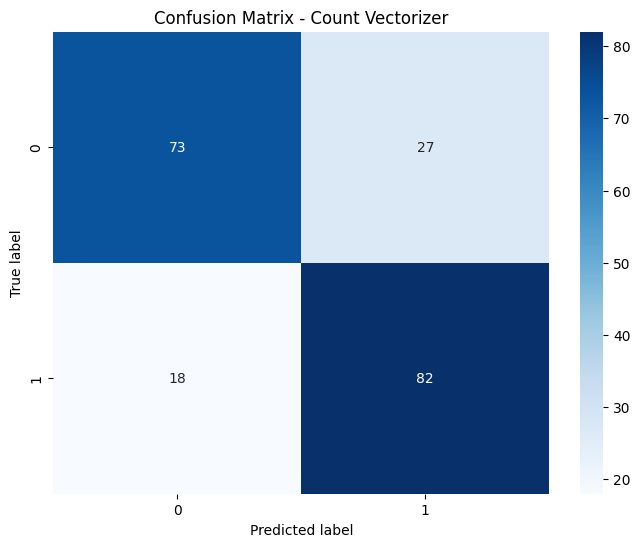

In [15]:
clf = LinearSVC( class_weight="balanced", max_iter=100, random_state=0)
clf.fit( Feats_Train_countvec, Labs_Train)

# Predict the classes of the testing data
predLabs_Test = clf.predict( Feats_Test_countvec )

# Evaluate the performance of the model using classification metrics
print(classification_report( Labs_Test, predLabs_Test ))

# Calculate the confusion matrix
cm = confusion_matrix( Labs_Test, predLabs_Test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Count Vectorizer')
plt.show()